In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from VQPCASuite.clustering import *
from VQPCASuite.evaluation import *
from VQPCASuite.preprocess import *

# Set times new roman as default
plt.rcParams['font.family'] = 'Times New Roman'

Index(['T', 'H', 'H2', 'O', 'OH', 'H2O', 'O2', 'HO2', 'H2O2', 'N2', 'AR',
       'HE'],
      dtype='object', name=0)


Text(0, 0.5, 'T [K]')

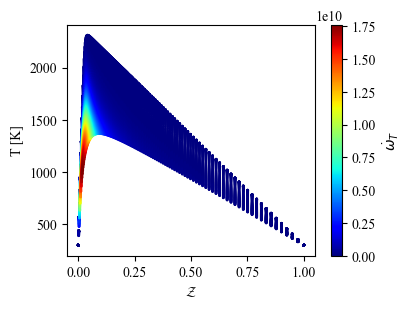

In [2]:
# Import flamalet data and plot mixture fraction vs temperature

# Load the hydrogen flamelet dataset
# Import the flamelet dataset
path_to_files = '/Users/matteosavarese/Desktop/Dottorato/Datasets/hydrogen-air-flamelet/'
filename = 'STEADY-clustered-flamelet-H2-'
# Import state space
state_space = pd.read_csv(path_to_files + filename + 'state-space.csv', header=None)
# Import state space sources
state_space_sources = pd.read_csv(path_to_files + filename + 'state-space-sources.csv', header=None)
# Import mixture fraction
mixture_fraction = pd.read_csv(path_to_files + filename + 'mixture-fraction.csv', header=None)
# Import heat release rate
heat_release_rate = pd.read_csv(path_to_files + filename + 'heat-release-rate.csv', header=None)
# Import dissipation rate 
dissipation_rates = pd.read_csv(path_to_files + filename + 'dissipation-rates.csv', header=None)
# Import state space names as a list of strings
state_space_names = pd.read_csv(path_to_files + filename + 'state-space-names.csv', header=None)
# Assign column names to the dataframes
state_space.columns = state_space_names.iloc[:,0]
state_space.head()
# Assign column names to the sources dataframe
state_space_sources.columns = state_space_names.iloc[:,0]

# Print column names
print(state_space.columns)

# ------------ Plot mixture fraction vs temperature colored by heat release rate ----------- #
fig, ax = plt.subplots(figsize=(4,3))
sc = ax.scatter(mixture_fraction, state_space.values[:,0], s=1, c=heat_release_rate.values, cmap='jet')
cb = fig.colorbar(sc, ax=ax)
cb.set_label('$\dot{\omega}_T$')
ax.set_xlabel('$\mathcal{Z}$')
ax.set_ylabel('T [K]')

In [3]:
# ------------ Data pre-processing ------------ #

# Select scaling method
method = 'auto'

# Initialize scaler
scaler = Scaler(method=method)

# Scale and center data
X_scaled = scaler.fit_transform(state_space.values)

# Project source term
Xsource_scaled = scaler.transform(state_space_sources.values, center=False)     # Source term must be scaled with the same scaling factor, but not centered

# Normalize source term
scaler_source = Scaler(method="range")
Xsource_norm  = scaler_source.fit_transform(Xsource_scaled)                     # Normalize for regression purposes

In [14]:
# ------------- Run VQPLS ------------ #
model = vqpls(itmax=150)

# Select number of clusters
nk = 8
# Select number of components
nc = 8
model.fit(X_scaled, Xsource_norm, n_clusters=nk, n_components=nc)

# Extract info
labels = model.labels


R2:  0.8977496561219843
MSE:  0.00047041308802311596
MAE:  0.007872356069389939
Iteration:  1
Delta centroids:  0.1633532131513081
Mean squared error:  0.00047041308802311596

R2:  0.9382490444942756
MSE:  0.0002151546520587418
MAE:  0.005334117759085495
Iteration:  2
Delta centroids:  0.09079303274374582
Mean squared error:  0.0002151546520587418

R2:  0.9540808126208272
MSE:  0.00014963700817951717
MAE:  0.0045703051599805
Iteration:  3
Delta centroids:  0.061167012943861246
Mean squared error:  0.00014963700817951717

R2:  0.9569407304413109
MSE:  0.00013066206113322997
MAE:  0.004300473115773105
Iteration:  4
Delta centroids:  0.03550969166985923
Mean squared error:  0.00013066206113322997

R2:  0.9584986859448845
MSE:  0.00011962712521446197
MAE:  0.004063598434023002
Iteration:  5
Delta centroids:  0.022914057651182144
Mean squared error:  0.00011962712521446197

R2:  0.9592985480014464
MSE:  0.00011390301694394803
MAE:  0.003944485716896619
Iteration:  6
Delta centroids:  0.0213

Text(0, 0.5, 'T [K]')

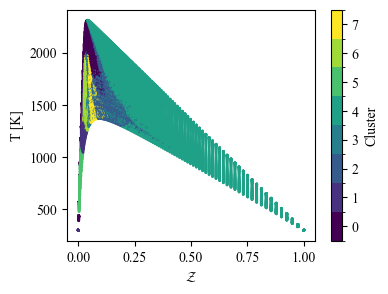

In [15]:
# Create discrete colormap
cmap = plt.cm.get_cmap('viridis')  # If you have Parula; if not, replace with 'viridis' or similar

# Create discrete colormap by selecting `n_clusters` colors from Parula
from matplotlib.colors import ListedColormap, BoundaryNorm
discrete_parula_cmap = ListedColormap(cmap(np.linspace(0, 1, nk)))

# Define boundaries and norm for discrete colormap
bounds = np.linspace(-0.5, nk - 0.5, nk + 1)
norm = BoundaryNorm(bounds, discrete_parula_cmap.N)

# Plot clustering results
fig, ax = plt.subplots(figsize=(4,3))
sc = ax.scatter(mixture_fraction, state_space.values[:,0], s=1, c=labels, cmap=discrete_parula_cmap, norm=norm)
cb = fig.colorbar(sc, ax=ax, ticks=np.arange(nk), boundaries=bounds)
cb.set_label('Cluster')
ax.set_xlabel('$\mathcal{Z}$')
ax.set_ylabel('T [K]')

Text(0.5, 1.0, 'PC 0')

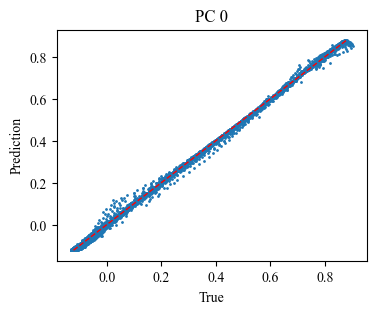

In [19]:
# Plot predictions
Y_pred = model.predict(X_scaled)

# Select a component to plot
idc = 0

# Parity plot
fig, ax = plt.subplots(figsize=(4,3))
sc = ax.scatter(Y_pred[:,idc], Xsource_norm[:,idc], s=1, label='pred')
# Plot middle line
xmin  = min(Xsource_norm[:,0])
xmax  = max(Xsource_norm[:,0])
l = ax.plot([xmin, xmax], [xmin, xmax], 'r--', linewidth=1, label='true')
# Set labels
ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.set_title("PC "+str(idc))